In [1]:
%load_ext watermark


In [2]:
from IPython.display import display, HTML
from hstrat import _auxiliary_lib as hstrat_aux
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib._calc_normed_defmut_clade_stats import (
    calc_normed_defmut_clade_stats,
)
from pylib._mask_sequence_diffs import mask_sequence_diffs
from pylib._screen_mutation_defined_nodes_sequence_diff import (
    screen_mutation_defined_nodes_sequence_diff,
)
from pylib._seed_global_rngs import seed_global_rngs


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-05-17T20:01:58.455973+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1027-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

numpy     : 2.1.2
seaborn   : 0.13.2
pandas    : 2.2.3
teeplot   : 1.4.2
hstrat    : 1.20.11
matplotlib: 3.9.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-05-16-vanilla-comparator"
teeplot_subdir


'2025-05-16-vanilla-comparator'

In [5]:
seed_global_rngs(1)


## Get Data


In [6]:
df = pd.read_parquet("https://osf.io/f4qaj/download").astype(
    {"origin_time": float},
)

df.head()


,source,target,date,layer,variant,sequence_focal,sequence_background,id,ancestor_id,origin_time,...,trt_seed,SLURM_JOB_ID,SLURM_ARRAY_JOB_ID,SLURM_ARRAY_TASK_ID,SLURM_ARRAY_TASK_COUNT,SLURM_ARRAY_TASK_MAX,SLURM_ARRAY_TASK_MIN,replicate_uuid,py_random_sample1,np_random_sample1
0,74486,74486,0,importation,Wildtype+,+,++++++++++++++++++++,0,0,0.0,...,0,56412948,56412946,0,15,14,0,f4ba679c-1205-8a4a-a1fd-e976d05e57ba,3626764237,2357136044
1,72893,72893,0,importation,Wildtype+,+,++++++++++++++++++++,1,0,0.0,...,0,56412948,56412946,0,15,14,0,f4ba679c-1205-8a4a-a1fd-e976d05e57ba,3626764237,2357136044
2,72971,72971,0,importation,Wildtype+,+,++++++++++++++++++++,2,0,0.0,...,0,56412948,56412946,0,15,14,0,f4ba679c-1205-8a4a-a1fd-e976d05e57ba,3626764237,2357136044
3,73093,73093,0,importation,Wildtype+,+,++++++++++++++++++++,3,0,0.0,...,0,56412948,56412946,0,15,14,0,f4ba679c-1205-8a4a-a1fd-e976d05e57ba,3626764237,2357136044
4,73103,73103,0,importation,Wildtype+,+,++++++++++++++++++++,4,0,0.0,...,0,56412948,56412946,0,15,14,0,f4ba679c-1205-8a4a-a1fd-e976d05e57ba,3626764237,2357136044


In [7]:
df["trt_name"].unique()


['Sben/Gneu', 'Sben/Gdel', 'Sneu/Gneu']
Categories (3, object): ['Sben/Gneu', 'Sben/Gdel', 'Sneu/Gneu']

In [8]:
dfx = df[
    (df["trt_name"] == "Sben/Gdel")
].reset_index(drop=True)

dfx = dfx[
    (dfx["replicate_uuid"] == dfx["replicate_uuid"].unique()[1])
]

dfx = hstrat_aux.alifestd_to_working_format(dfx).reset_index(drop=True)


In [9]:
# yield (mut_char_pos, mut_char_ref, mut_char_var), mut_mask
mutations = mask_sequence_diffs(
    ancestral_sequence=dfx["ancestral_sequence"].astype(str).unique().item(),
    sequence_diffs=dfx["sequence_diff"],
    sparsify_mask=False,
)
mutations = [*mutations]
mutations[:5]


enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.004238128662109375}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00027441978454589844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005996227264404297}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 4.57763671875e-05}
ancestral_sequence[0]='+' 
int(mut_unique[0])=39
int(mut_unique[0] >> 8)=0
chr(mut_unique[0] & 0xFF)="'"
int(mut_counts[0])=2741
int(mut_counts[0]) / len(sequence_diffs)=0.023477918251276254
enter log_context_duration for is_valid_mut
is_valid_mut[0]=True
(mut_counts[is_valid_mut] < mut_counts[0]).mean()=0.9523809523809523
exit log_context_duration for is_valid_mut
!!! {"is_valid_mut": 0.00029778480529785156}
len(is_valid_mut)=21 is_valid_mut.sum()=21 is_valid_mut[0]=True
enter log_context_duration 

[((0, '+', "'"), array([False, False, False, ...,  True, False,  True])),
 ((1, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((2, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((3, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((4, '+', "'"), array([False, False, False, ..., False, False, False]))]

In [10]:

defining_masks = {
    (mut_char_pos, mut_char_ref, mut_char_var): screen_mutation_defined_nodes_sequence_diff(
        phylo_df=dfx,
        mut_char_pos=mut_char_pos,
        mut_char_var=mut_char_var,
    )
    for (mut_char_pos, mut_char_ref, mut_char_var), mut_mask in mutations
}
dfx["is_focal_mutant"] = next(iter(defining_masks.values()))
[*defining_masks.items()][:5]


[((0, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((1, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((2, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((3, '+', "'"), array([False, False, False, ..., False, False, False])),
 ((4, '+', "'"), array([False, False, False, ..., False, False, False]))]

In [11]:
dfx = calc_normed_defmut_clade_stats(
    phylo_df=dfx,
    defmut_clade_masks=defining_masks,
    match_cols=["variant_flavor"],
    ot_deltas=(4, 7, 14, 28, 44),
    progress_wrap=tqdm,
)


 97%|█████████▋| 2661/2752 [00:02<00:00, 1222.70it/s]/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


In [12]:
def stripboxen_plot(
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: str
) -> plt.Axes:
    ax = sns.boxenplot(
        data=data,
        y=y,
        x=x,
        hue=hue,
        legend=False,
    )
    sns.barplot(
        data=data,
        y=y,
        x=x,
        hue=hue,
        alpha=0.0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        y=data[y] + np.random.uniform(-1, 1, len(data)),
        x=data[x],
        alpha=0.2,
        ax=ax,
        color="k",
        legend=False,
        jitter=0.3,
        size=4,
    )
    return ax


teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-all-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-all-num-leaves+ext=.png


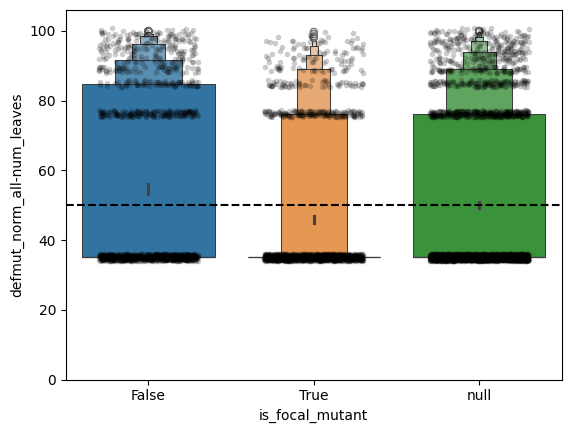

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-4-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-4-num-leaves+ext=.png


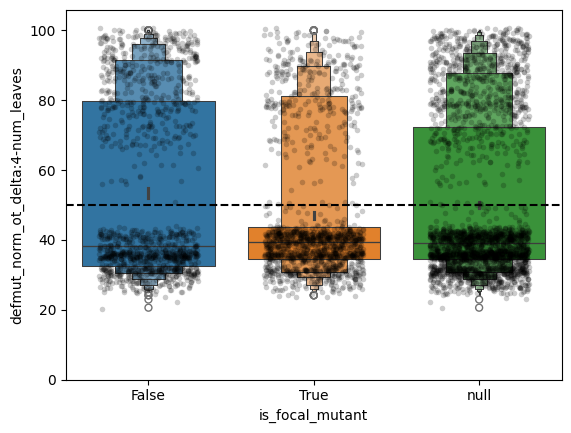

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-7-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-7-num-leaves+ext=.png


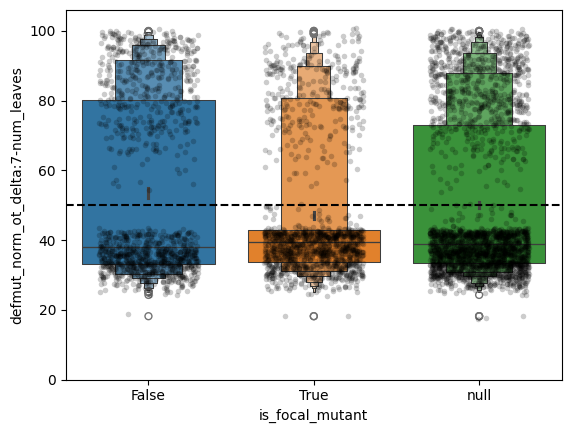

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-14-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-14-num-leaves+ext=.png


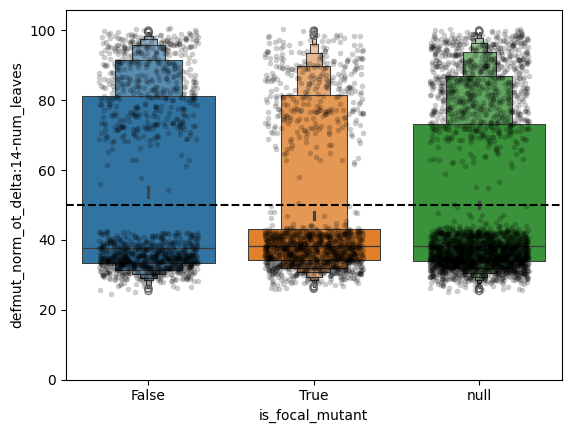

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-28-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-28-num-leaves+ext=.png


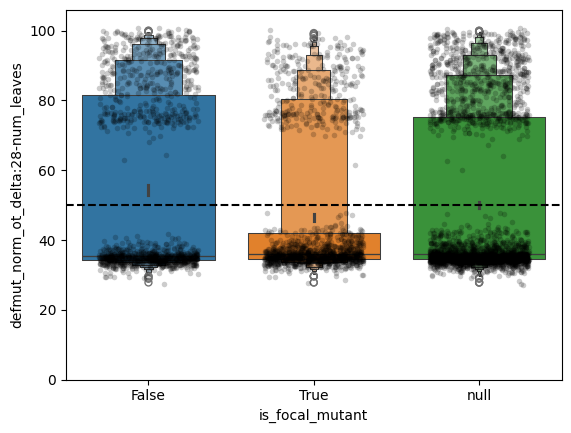

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-44-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-44-num-leaves+ext=.png


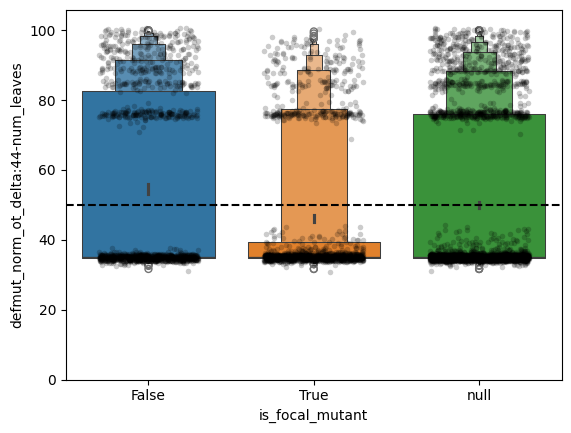

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-match-variant-flavor-num-leaves+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-match-variant-flavor-num-leaves+ext=.png


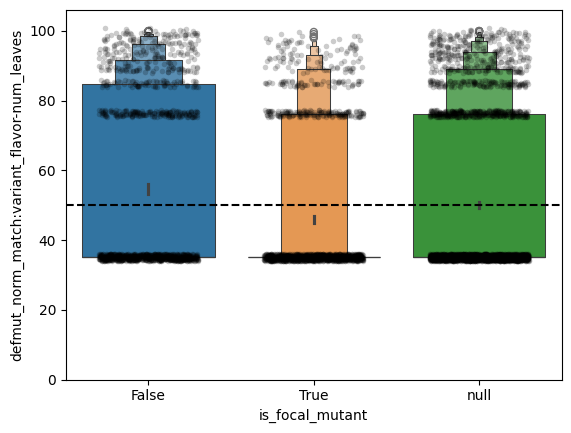

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-all-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-all-clade-duration+ext=.png


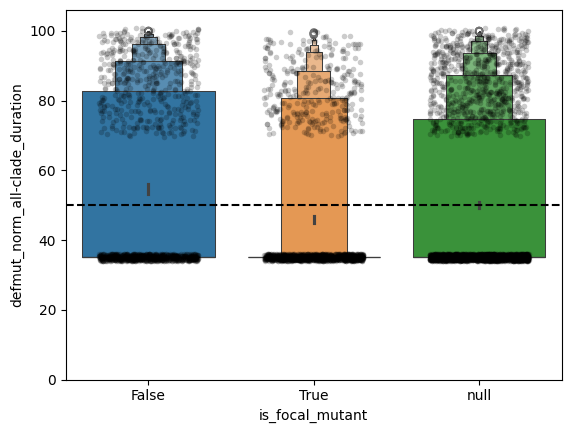

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-4-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-4-clade-duration+ext=.png


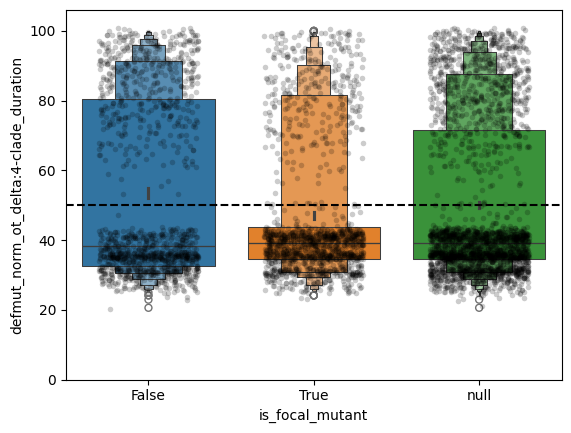

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-7-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-7-clade-duration+ext=.png


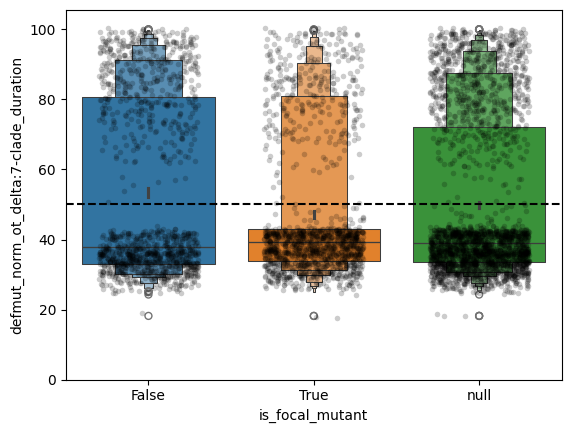

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-14-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-14-clade-duration+ext=.png


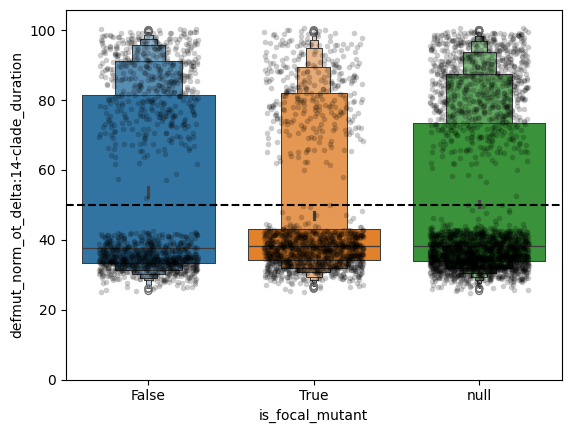

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-28-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-28-clade-duration+ext=.png


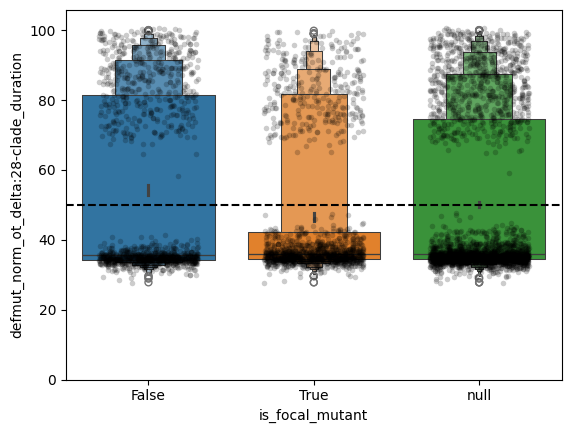

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-44-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-ot-delta-44-clade-duration+ext=.png


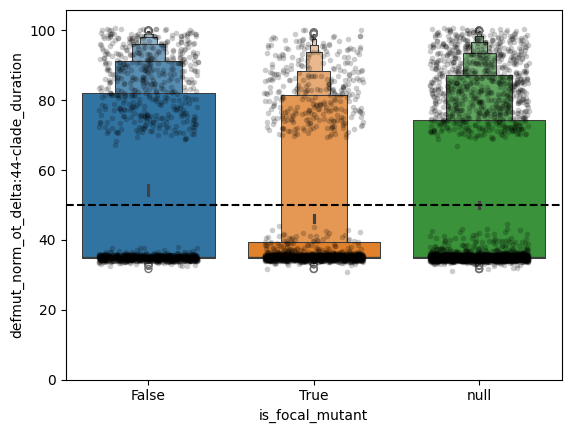

teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-match-variant-flavor-clade-duration+ext=.pdf
teeplots/2025-05-16-vanilla-comparator/hue=is-focal-mutant+viz=stripboxen-plot+x=is-focal-mutant+y=defmut-norm-match-variant-flavor-clade-duration+ext=.png


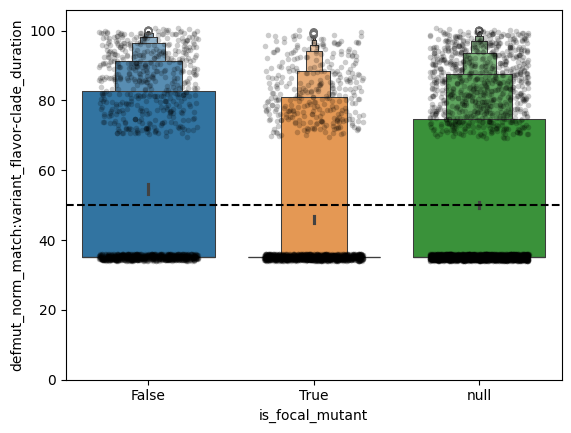

In [13]:
dfx_ = dfx.copy()
dfx_["is_focal_mutant"] = "null"
data = pd.concat([dfx, dfx_], ignore_index=True)

for y in (
    "defmut_norm_all-num_leaves",
    "defmut_norm_ot_delta:4-num_leaves",
    "defmut_norm_ot_delta:7-num_leaves",
    "defmut_norm_ot_delta:14-num_leaves",
    "defmut_norm_ot_delta:28-num_leaves",
    "defmut_norm_ot_delta:44-num_leaves",
    "defmut_norm_match:variant_flavor-num_leaves",
    "defmut_norm_all-clade_duration",
    "defmut_norm_ot_delta:4-clade_duration",
    "defmut_norm_ot_delta:7-clade_duration",
    "defmut_norm_ot_delta:14-clade_duration",
    "defmut_norm_ot_delta:28-clade_duration",
    "defmut_norm_ot_delta:44-clade_duration",
    "defmut_norm_match:variant_flavor-clade_duration",
):
    display(HTML(f"<h2>{y}</h2>"))
    with tp.teed(
        stripboxen_plot,
        data=data,
        x="is_focal_mutant",
        y=y,
        hue="is_focal_mutant",
        teeplot_subdir=teeplot_subdir,
    ) as teed:
        teed.axhline(50, color="k", linestyle="--")

    plt.show()
